In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display
import mrmr 

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# --- NUOVA IMPORTAZIONE ---
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import BayesianRidge
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Import dei classificatori
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_rows', 100) # Mostra fino a 100 righe
pd.set_option('display.max_columns', 50) # Mostra fino a 50 colonne
pd.set_option('display.width', 1000) # Aumenta la larghezza massima della visualizzazione

PKL_PATH = "../data/interim/"
INPUT_PKL_FILENAME = "preprocessed.pkl"

TARGET_VARIABLE = 'decision'
SEED = 37  # Per la riproducibilità

df = pd.read_pickle(PKL_PATH + INPUT_PKL_FILENAME)

In [14]:
X = df.drop(columns=[TARGET_VARIABLE])      # RICORDA: non sono vere copie indipendenti del DataFrame
y = df[TARGET_VARIABLE]

categorical_columns = ['race', 'race_o', 'field']
binary_text_columns = ['gender']
binary_numeric_columns = ['samerace']
numeric_columns = [
    col for col in X.select_dtypes(include=['int64', 'float64']).columns
    if col not in binary_numeric_columns
]

assert len(categorical_columns) + len(binary_text_columns) + len(binary_numeric_columns) + len(numeric_columns) == len(df.columns) - 1

In [15]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y)

In [16]:
# 3. Ora, CALCOLA scale_pos_weight SOLO SU y_train
# Supponiamo che la classe negativa sia 0 e la positiva sia 1
# y_train è una Series di pandas
counts = y_train.value_counts()
count_negative = counts[0]  # Numero di campioni con etichetta 0
count_positive = counts[1]  # Numero di campioni con etichetta 1

# La formula standard e più comune per calcolare scale_pos_weight è:
# scale_pos_weight = Numero di esempi della classe negativa / Numero di esempi della classe positiva

if count_positive > 0:
    scale_pos_weight_value = count_negative / count_positive
else:
    # Gestisci il caso in cui non ci sono esempi positivi nel training set (improbabile con stratify)
    scale_pos_weight_value = 1 

print(f"Rapporto Negativi/Positivi nel training set: {scale_pos_weight_value:.2f}")

Rapporto Negativi/Positivi nel training set: 1.37


In [17]:
# --- Pipeline per le colonne NUMERICHE STANDARD ---
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(
        estimator=BayesianRidge(), 
        max_iter=20, 
        random_state=SEED
    )),
    ('scaler', RobustScaler())
])

# --- Pipeline per le colonne CATEGORICHE ---
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore', 
        drop='first',
        sparse_output=False  # <-- ECCO LA MODIFICA!
    ))
])

# Usiamo OrdinalEncoder, che è standard e supporta l'API set_output.
binary_text_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(
        # Specifichiamo l'ordine per garantire 'female'->0, 'male'->1
        categories=[['female', 'male']], 
        # Gestisce valori non visti trasformandoli in NaN
        handle_unknown='use_encoded_value', 
        unknown_value=np.nan 
    )),
    # L'imputer gestirà sia i NaN originali sia quelli creati da handle_unknown
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Pipeline per 'samerace' (che è già quasi a posto)
binary_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


# 3. Combinazione di TUTTO con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('bin_text', binary_text_transformer, binary_text_columns),
        ('bin_num', binary_numeric_transformer, binary_numeric_columns)
    ],
    remainder='drop',
    verbose_feature_names_out=False # Utile per avere nomi di feature più puliti
)
preprocessor.set_output(transform="pandas") # Fondamentale per far funzionare mRMR con i nomi delle colonne

,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,estimator,BayesianRidge()
,missing_values,nan
,sample_posterior,False


In [18]:
# ----------------------------------------------------------------------------------
# --- PASSO 1: CREAZIONE DEL TRASFORMATORE PERSONALIZZATO PER mRMR ---
# ----------------------------------------------------------------------------------
# Creiamo una classe che si integra perfettamente con le pipeline di Scikit-learn.
# Eredita da BaseEstimator e TransformerMixin per ottenere i metodi standard.

class MRMRSelector(BaseEstimator, TransformerMixin):
    """
    Un selettore di feature personalizzato che utilizza l'algoritmo mRMR.
    
    Parametri:
    -----------
    k : int or str
        Il numero di feature da selezionare. Se 'all', tutte le feature
        vengono mantenute (utile per la grid search).
    """
    def __init__(self, k=10):
        self.k = k
        self.selected_features_ = None

    def fit(self, X, y):
        # La nostra pipeline ora produce un DataFrame Pandas grazie a set_output()
        # quindi X ha i nomi delle colonne, necessari per mrmr_classif.
        
        # Gestiamo il caso speciale 'all' per la GridSearch
        if self.k == 'all':
            self.selected_features_ = X.columns.tolist()
        else:
            # Assicuriamoci che k non sia più grande del numero di feature disponibili
            num_features_to_select = min(self.k, X.shape[1])
            
            # Usiamo la funzione mrmr_classif per ottenere la lista delle migliori feature
            # NOTA: relevance e redundancy sono i default, ma possono essere cambiati
            self.selected_features_ = mrmr.mrmr_classif(
                X=X, 
                y=y, 
                K=num_features_to_select
            )
        return self

    def transform(self, X):
        # Selezioniamo solo le colonne che sono state identificate nel metodo fit
        return X[self.selected_features_]
        
    def get_feature_names_out(self, input_features=None):
        # Metodo standard per propagare i nomi delle feature nella pipeline
        return np.array(self.selected_features_)


In [19]:
estimators = {
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=SEED),
    # 'xgboost': XGBClassifier(random_state=SEED, eval_metric='logloss'),
    'catboost': CatBoostClassifier(random_state=SEED, verbose=0, allow_writing_files=False),
    # 'random_forest': RandomForestClassifier(random_state=SEED, n_jobs=-1),
}

param_grids = {
    'hist_gradient_boosting': {
        # Sostituiamo i parametri di SelectKBest con il parametro 'k' del nostro MRMRSelector
        'selector__k': [40, 50, 'all'],

        'model__learning_rate': [0.03, 0.05],
        'model__max_depth': [7],
        'model__class_weight': ['balanced'],
        'model__max_iter': [180, 220],
        'model__l2_regularization': [1.0, 1.5]
    },
    # --> Combinazioni totali: 2 * 1 * 1 * 2 * 2 = 8 Combinazioni

    # 'xgboost': {
    #     'model__learning_rate': [0.05],
    #     'model__max_depth': [5],
    #     'model__scale_pos_weight': [scale_pos_weight_value],
    #     'model__subsample': [0.8],
    #     'model__n_estimators': [200, 220],
    #     'model__gamma': [1.0, 1.5],
    #     'model__colsample_bytree': [0.8, 1.0] 
    # },
    # # --> Combinazioni totali: 1 * 1 * 1 * 1 * 2 * 2 * 2 = 8 Combinazioni

    'catboost': {
        'selector__k': [40, 50, 'all'],

        'model__learning_rate': [0.05],
        'model__depth': [6],
        'model__scale_pos_weight': [scale_pos_weight_value],
        'model__subsample': [0.8],
        'model__iterations': [280, 300, 320, 340],
        'model__l2_leaf_reg': [5, 6],
        'model__random_strength': [1.0]
    },
    # --> Combinazioni totali: 1 * 1 * 1 * 1 * 4 * 2 * 1 = 8

    # 'random_forest': {
    #     'model__n_estimators': [200, 250],
    #     'model__max_depth': [9, 10],
    #     'model__min_samples_leaf': [3, 5],
    #     'model__min_samples_split': [10],
    #     'model__max_features': [0.7],
    #     'model__criterion': ['entropy'],
    #     'model__class_weight': ['balanced_subsample']
    # }
    # # --> Combinazioni totali: 2 * 2 * 2 * 1 * 1 * 1 = 8 Combinazioni
}

In [20]:
# Definiamo le metriche di scoring
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Decidiamo su quale metrica fare il refit
refit_metric = 'f1'

### Model Training and Hyperparameter Optimization

In [ ]:
# Dizionari per salvare i risultati finali
results = {}
best_estimators = {}    # dizionario che conterrà i migliori stimatori per ogni modello, già addestrati e pronti per essere usati.
all_cv_results = {}

for name, model in estimators.items():
    model_title = name.replace('_', ' ').title()
    print(f"\n--- Esecuzione GridSearchCV per: {model_title} ---")
    start_time = time.time()

    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', MRMRSelector()), # Lo lasciamo vuoto, la GridSearch lo popolerà
        ('model', model)
    ])

    # Definiamo la GridSearchCV con le metriche multiple
    grid_search = GridSearchCV(
        estimator = full_pipeline,
        param_grid = param_grids[name],
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED),
        scoring = scoring_metrics,
        refit = refit_metric,
        n_jobs = -1,
        verbose = 5,
        return_train_score=True # Fondamentale per avere gli score di train
    )

    grid_search.fit(X_train, y_train)
    end_time = time.time()
    execution_time = (end_time - start_time) / 60

    # Salvataggio dei risultati principali
    results[name] = {
        'best_score_cv': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'execution_time_minutes': execution_time
    }
    best_estimators[name] = grid_search.best_estimator_
    all_cv_results[name] = pd.DataFrame(grid_search.cv_results_)
    
    print(f"Miglior F1-score (CV) per {model_title}: {grid_search.best_score_:.4f}")
    print(f"Tempo di esecuzione: {execution_time:.2f} minuti")

    # ---------------------------------------------------------------------
    # --- Visualizzazione Dettagliata per il Modello Corrente ---
    # ---------------------------------------------------------------------
    print(f"\n--- Dettaglio Risultati GridSearchCV per {model_title} ---\n")
    
    # Estraiamo i risultati
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    
    # Definiamo le colonne che ci interessano
    param_columns = [f'param_{key}' for key in param_grids[name].keys()]
    
    # RICORDA: quando qui si parla di test e train set, si intendono sempre quelli interni alla CV
    score_columns = [
        'mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc',
        'mean_train_accuracy', 'mean_train_f1', 'mean_train_roc_auc',
        f'rank_test_{refit_metric}', 'rank_test_accuracy'
    ]
    
    # Creiamo la tabella da visualizzare
    columns_to_show =  score_columns + param_columns
    model_results_table = cv_results_df[columns_to_show].copy()
    model_results_table.rename(columns=lambda x: x.replace('param_model__', ''), inplace=True)
    model_results_table.rename(columns=lambda x: x.replace('param_selector__', ''), inplace=True)
    
    model_results_table.sort_values(by=f'rank_test_{refit_metric}', inplace=True)
    
    # Mostriamo la tabella
    display(model_results_table.head(20))
    print("-" * 80)
    # ---------------------------------------------------------------------




--- Esecuzione GridSearchCV per: Hist Gradient Boosting ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Miglior F1-score (CV) per Hist Gradient Boosting: 0.6486
Tempo di esecuzione: 3.74 minuti

--- Dettaglio Risultati GridSearchCV per Hist Gradient Boosting ---



,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,rank_test_f1,rank_test_accuracy,k,learning_rate,max_depth,class_weight,max_iter,l2_regularization
20,0.696576,0.648594,0.760740,0.867066,0.847955,0.944397,1,3,all,0.05,7,balanced,180,1.5
17,0.694591,0.647860,0.758294,0.842645,0.820145,0.924922,2,10,all,0.03,7,balanced,220,1.5
5,0.696009,0.647700,0.759975,0.844810,0.822664,0.927542,3,4,all,0.03,7,balanced,220,1.0
4,0.695583,0.647265,0.758172,0.841083,0.818577,0.923538,4,6,50,0.03,7,balanced,220,1.0
16,0.694873,0.646872,0.755382,0.838776,0.815738,0.921367,5,9,50,0.03,7,balanced,220,1.5
23,0.695441,0.646811,0.762172,0.885170,0.868406,0.957512,6,7,all,0.05,7,balanced,220,1.5
10,0.697569,0.646713,0.761455,0.884105,0.866969,0.955964,7,1,50,0.05,7,balanced,220,1.0
11,0.696862,0.646469,0.761317,0.888968,0.872411,0.959648,8,2,all,0.05,7,balanced,220,1.0
2,0.693028,0.645926,0.757560,0.829937,0.805775,0.914811,9,14,all,0.03,7,balanced,180,1.0
22,0.695298,0.645923,0.759200,0.879739,0.862469,0.953642,10,8,50,0.05,7,balanced,220,1.5


### Riepilogo e Confronto dei Modelli

In [ ]:
# --- 4. Analisi e Confronto Finale (Versione Pulita) ---
print("\n\n--- Riepilogo e Confronto dei Modelli ---")

# Lista per contenere i dati di riepilogo per ogni modello
summary_data = []

# Iteriamo sui DataFrame dei risultati della CV che hai salvato in all_cv_results
# 'name' sarà 'xgboost', 'catboost', etc.
# 'cv_results_df' sarà il DataFrame completo dei risultati per quel modello
for name, cv_results_df in all_cv_results.items():
    
    # Troviamo l'indice della riga con il miglior modello (quello scelto da refit='f1')
    # Il rank è 1 per il migliore, quindi cerchiamo la riga dove rank_test_f1 == 1
    best_model_index = cv_results_df[f'rank_test_{refit_metric}'].idxmin()
    
    # Estraiamo l'intera riga (che è una Series) contenente tutti i dati di quel modello
    best_result_series = cv_results_df.loc[best_model_index]
    
    # Aggiungiamo un dizionario con le informazioni che ci interessano alla nostra lista
    summary_data.append({
        'model': name.replace('_', ' ').title(),
        'mean_test_accuracy': best_result_series['mean_test_accuracy'],
        'mean_test_f1': best_result_series['mean_test_f1'],
        'mean_test_roc_auc': best_result_series['mean_test_roc_auc'],
        'mean_train_accuracy': best_result_series['mean_train_accuracy'],
        'mean_train_f1': best_result_series['mean_train_f1'],
        'mean_train_roc_auc': best_result_series['mean_train_roc_auc'],
        # Aggiungiamo anche il tempo di esecuzione e i parametri migliori per riferimento
        'execution_time_minutes': results[name]['execution_time_minutes']
    })

# Creiamo il DataFrame di confronto finale dalla lista di dizionari
comparison_df = pd.DataFrame(summary_data)
# Usiamo il nome del modello come indice della tabella
comparison_df.set_index('model', inplace=True)

# Ordiniamo la tabella in base alla metrica più importante (F1 di test)
comparison_df = comparison_df.sort_values(by='mean_test_f1', ascending=False)

# Applichiamo una formattazione per una migliore leggibilità
# Selezioniamo tutte le colonne tranne il tempo di esecuzione
float_cols = [col for col in comparison_df.columns if 'time' not in col]

# Formattiamo le colonne degli score a 4 cifre decimali
for col in float_cols:
    comparison_df[col] = comparison_df[col].map('{:.4f}'.format)

# Formattiamo la colonna del tempo a 2 cifre decimali
comparison_df['execution_time_minutes'] = comparison_df['execution_time_minutes'].map('{:.2f}'.format)


# Mostriamo la tabella di confronto finale
print("Tabella di confronto dei modelli ordinata per F1-score (CV):")
display(comparison_df)



--- Riepilogo e Confronto dei Modelli ---
Tabella di confronto dei modelli ordinata per F1-score (CV):


,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,execution_time_minutes
model,,,,,,,
Hist Gradient Boosting,0.6990,0.6495,0.7638,0.8883,0.8716,0.9591,2.95


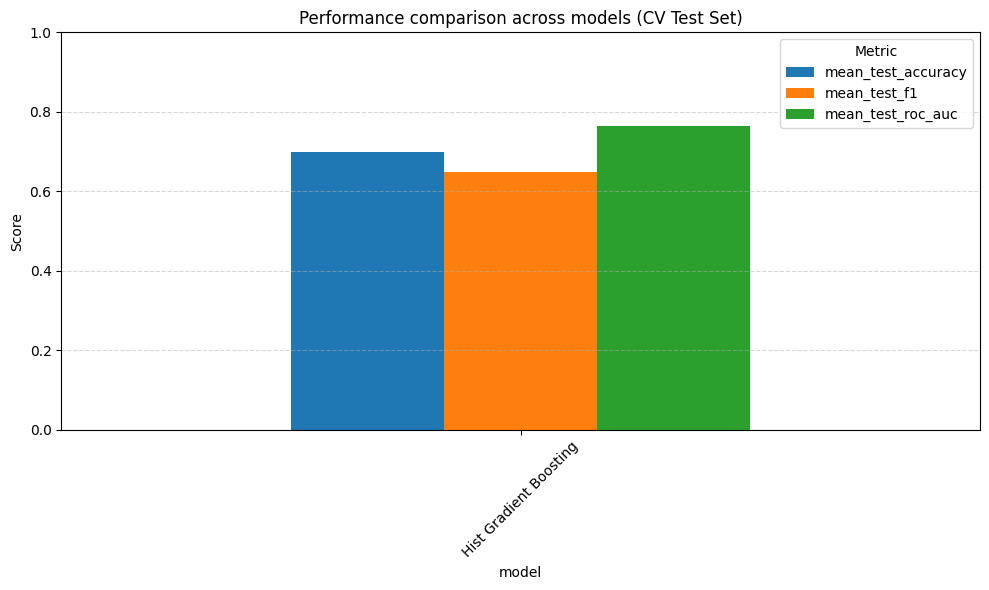

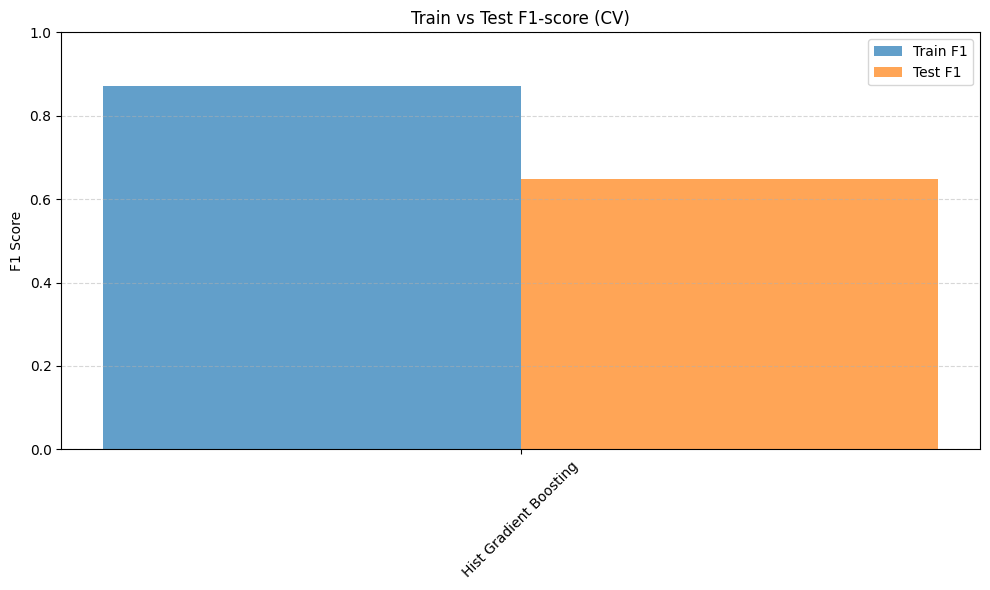

In [ ]:
# Copia del DataFrame per lavorare con valori numerici (prima della formattazione)
comparison_numeric = comparison_df.copy()
for col in comparison_numeric.columns:
    comparison_numeric[col] = pd.to_numeric(comparison_numeric[col], errors='coerce')

# === 1. Confronto metriche di test: Accuracy, F1, ROC AUC ===
metrics_to_plot = ['mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc']

comparison_numeric[metrics_to_plot].plot(kind='bar', figsize=(10, 6))
plt.title('Performance comparison across models (CV Test Set)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# === 2. Confronto Train vs Test per F1 ===
plt.figure(figsize=(10, 6))
bar_width = 0.35
indices = range(len(comparison_numeric))

plt.bar(indices, comparison_numeric['mean_train_f1'], width=bar_width, label='Train F1', alpha=0.7)
plt.bar([i + bar_width for i in indices], comparison_numeric['mean_test_f1'], width=bar_width, label='Test F1', alpha=0.7)

plt.title('Train vs Test F1-score (CV)')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks([i + bar_width / 2 for i in indices], comparison_numeric.index, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Confronto approfondito tra i due migliori modelli

In [ ]:
# =================================================================================
# === INIZIO BLOCCO PER IL CONFRONTO STATISTICO DINAMICO ===
# =================================================================================

# --- Fase 1: Selezione Dinamica dei Modelli da Confrontare ---
# Useremo i risultati già calcolati e presenti in `comparison_df`
# MA prima della formattazione in stringa, per poter usare idxmax()

# Ricreiamo un DataFrame di confronto con valori numerici (se non lo hai più)
summary_data_numeric = []
for name, cv_results_df in all_cv_results.items():
    best_model_index = cv_results_df[f'rank_test_{refit_metric}'].idxmin()
    best_result_series = cv_results_df.loc[best_model_index]
    summary_data_numeric.append({
        'model': name, # Salviamo il nome originale, es. 'hist_gradient_boosting'
        'mean_test_accuracy': best_result_series['mean_test_accuracy'],
        'mean_test_f1': best_result_series['mean_test_f1']
    })
comparison_df_numeric = pd.DataFrame(summary_data_numeric).set_index('model')

# Ora troviamo i nomi dei modelli migliori in modo dinamico
model_best_accuracy_name = comparison_df_numeric['mean_test_accuracy'].idxmax()
model_best_f1_name = comparison_df_numeric['mean_test_f1'].idxmax()

# Estraiamo i modelli corrispondenti dal dizionario degli stimatori
model_a = best_estimators[model_best_accuracy_name]
model_b = best_estimators[model_best_f1_name]

print("\n--- Selezione Dinamica per Confronto Statistico ---")
print(f"Modello A (Miglior Accuracy in CV): {model_best_accuracy_name.replace('_', ' ').title()}")
print(f"  - Accuracy in CV: {comparison_df_numeric.loc[model_best_accuracy_name, 'mean_test_accuracy']:.4f}")

print(f"Modello B (Miglior F1-Score in CV): {model_best_f1_name.replace('_', ' ').title()}")
print(f"  - F1-Score in CV: {comparison_df_numeric.loc[model_best_f1_name, 'mean_test_f1']:.4f}")

# Controlliamo se per caso è stato selezionato lo stesso modello per entrambe le metriche
if model_best_accuracy_name == model_best_f1_name:
    print("\nATTENZIONE: Il modello con la migliore accuracy e il migliore F1-score è lo stesso.")
    print("Il confronto statistico non verrà eseguito perché si confronterebbe un modello con se stesso.")
else:
    # --- Fase 2: Esecuzione del Test con Ricampionamento su X_test ---
    # (Questa parte rimane identica)

    cv_test = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=SEED)
    scores_a_accuracy, scores_b_accuracy = [], []
    scores_a_f1, scores_b_f1 = [], []

    print("\nEsecuzione del confronto con RepeatedStratifiedKFold sul TEST SET...")
    for _, test_fold_idx in cv_test.split(X_test, y_test):
        X_fold = X_test.iloc[test_fold_idx]
        y_fold = y_test.iloc[test_fold_idx]

        # Modello A (Best Accuracy)
        y_pred_a = model_a.predict(X_fold)
        scores_a_accuracy.append(accuracy_score(y_fold, y_pred_a))
        scores_a_f1.append(f1_score(y_fold, y_pred_a, average='binary')) # Cambia in 'macro' se multiclasse

        # Modello B (Best F1)
        y_pred_b = model_b.predict(X_fold)
        scores_b_accuracy.append(accuracy_score(y_fold, y_pred_b))
        scores_b_f1.append(f1_score(y_fold, y_pred_b, average='binary')) # Cambia in 'macro' se multiclasse

    print("Confronto completato.")

    scores_a_accuracy = np.array(scores_a_accuracy)
    scores_b_accuracy = np.array(scores_b_accuracy)
    scores_a_f1 = np.array(scores_a_f1)
    scores_b_f1 = np.array(scores_b_f1)
    
    # --- Fase 3 e 4: Analisi Statistica e Visualizzazione ---
    # (Questa parte rimane identica)

    diff_accuracy = scores_a_accuracy - scores_b_accuracy
    diff_f1 = scores_a_f1 - scores_b_f1

    print("\n--- Risultati Medi sul Test Set (basati su ricampionamento) ---")
    print(f"Accuracy media Modello A ({model_best_accuracy_name}): {scores_a_accuracy.mean():.4f} +/- {scores_a_accuracy.std():.4f}")
    print(f"Accuracy media Modello B ({model_best_f1_name}): {scores_b_accuracy.mean():.4f} +/- {scores_b_accuracy.std():.4f}")
    print("-" * 20)
    print(f"F1-Score medio Modello A ({model_best_accuracy_name}): {scores_a_f1.mean():.4f} +/- {scores_a_f1.std():.4f}")
    print(f"F1-Score medio Modello B ({model_best_f1_name}): {scores_b_f1.mean():.4f} +/- {scores_b_f1.std():.4f}")
    
    # --- Visualizzazione della Distribuzione delle Differenze ---
    print("\n--- Ispezione Visiva della Normalità delle Differenze ---")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Distribuzione delle Differenze di Performance (Modello A - Modello B)', fontsize=16)

    # Istogramma e Q-Q plot per le differenze di ACCURACY
    sns.histplot(diff_accuracy, kde=True, bins=15, ax=axes[0], color='cornflowerblue')
    axes[0].set_title(f'Distribuzione Differenze Accuracy\n({model_best_accuracy_name} - {model_best_f1_name})')
    axes[0].set_xlabel('Differenza in Accuracy')
    axes[0].set_ylabel('Frequenza')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Istogramma e Q-Q plot per le differenze di F1-SCORE
    sns.histplot(diff_f1, kde=True, bins=15, ax=axes[1], color='salmon')
    axes[1].set_title(f'Distribuzione Differenze F1-Score\n({model_best_accuracy_name} - {model_best_f1_name})')
    axes[1].set_xlabel('Differenza in F1-Score')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

    # Creiamo anche i Q-Q Plot per un'analisi più rigorosa della normalità
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Q-Q Plot delle Differenze di Performance', fontsize=16)

    stats.probplot(diff_accuracy, dist="norm", plot=axes[0])
    axes[0].set_title('Q-Q Plot per Differenze di Accuracy')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    stats.probplot(diff_f1, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot per Differenze di F1-Score')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()
    # =================================================================================

    # Test di normalità
    shapiro_stat_acc, shapiro_p_acc = stats.shapiro(diff_accuracy)
    shapiro_stat_f1, shapiro_p_f1 = stats.shapiro(diff_f1)
    print("\n--- Test di Normalità sulle Differenze (Shapiro-Wilk) ---")
    print(f"P-value per le differenze di Accuracy: {shapiro_p_acc:.4f}")
    print(f"P-value per le differenze di F1-Score: {shapiro_p_f1:.4f}")

    # Test statistico
    alpha = 0.05
    # Test per Accuracy
    if shapiro_p_acc > alpha:
        print("\nLe differenze di accuracy sembrano normali. -> Eseguo t-test appaiato.")
        stat, p_value = stats.ttest_rel(scores_a_accuracy, scores_b_accuracy)
    else:
        print("\nLe differenze di accuracy NON sembrano normali. -> Eseguo test di Wilcoxon.")
        stat, p_value = stats.wilcoxon(scores_a_accuracy, scores_b_accuracy, zero_method='zsplit')
    print(f"Risultato test per Accuracy: Statistica={stat:.4f}, p-value={p_value:.4f}")
    if p_value < alpha:
        print("-> La differenza tra i modelli in termini di ACCURACY è statisticamente significativa.")
    else:
        print("-> La differenza tra i modelli in termini di ACCURACY NON è statisticamente significativa.")

    # Test per F1-Score
    if shapiro_p_f1 > alpha:
        print("\nLe differenze di F1-score sembrano normali. -> Eseguo t-test appaiato.")
        stat, p_value = stats.ttest_rel(scores_a_f1, scores_b_f1)
    else:
        print("\nLe differenze di F1-score NON sembrano normali. -> Eseguo test di Wilcoxon.")
        stat, p_value = stats.wilcoxon(scores_a_f1, scores_b_f1, zero_method='zsplit')
    print(f"Risultato test per F1-Score: Statistica={stat:.4f}, p-value={p_value:.4f}")
    if p_value < alpha:
        print("-> La differenza tra i modelli in termini di F1-SCORE è statisticamente significativa.")
    else:
        print("-> La differenza tra i modelli in termini di F1-SCORE NON è statisticamente significativa.")

    # --- Visualizzazione --------------------
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    # Definiamo le etichette una sola volta per non ripetere codice
    labels = [
        model_best_accuracy_name.replace('_', ' ').title(), 
        model_best_f1_name.replace('_', ' ').title()
    ]

    # --- Grafico 1: Accuracy ---
    sns.boxplot(data=[scores_a_accuracy, scores_b_accuracy], ax=axes[0], palette="Set2")
    axes[0].set_title("Distribuzione delle Accuracy sul Test Set")
    axes[0].set_ylabel("Accuracy Score")
    # FIX: Specifichiamo le posizioni dei tick PRIMA di impostare le etichette
    axes[0].set_xticks([0, 1]) 
    axes[0].set_xticklabels(labels, rotation=10)

    # --- Grafico 2: F1-Score ---
    sns.boxplot(data=[scores_a_f1, scores_b_f1], ax=axes[1], palette="Set2")
    axes[1].set_title("Distribuzione degli F1-Score sul Test Set")
    axes[1].set_ylabel("F1-Score")
    # FIX: Specifichiamo le posizioni dei tick PRIMA di impostare le etichette
    axes[1].set_xticks([0, 1]) 
    axes[1].set_xticklabels(labels, rotation=10)

    # Impostazioni finali della figura
    plt.suptitle("Confronto delle Performance dei Modelli tramite Ricampionamento", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
# =================================================================================
# === FINE BLOCCO PER IL CONFRONTO STATISTICO ===
# =================================================================================


--- Selezione Dinamica per Confronto Statistico ---
Modello A (Miglior Accuracy in CV): Hist Gradient Boosting
  - Accuracy in CV: 0.6990
Modello B (Miglior F1-Score in CV): Hist Gradient Boosting
  - F1-Score in CV: 0.6495

ATTENZIONE: Il modello con la migliore accuracy e il migliore F1-score è lo stesso.
Il confronto statistico non verrà eseguito perché si confronterebbe un modello con se stesso.


### Valutazione del Modello Migliore sul Test Set - DA AGGIUSTARE POST RICEVIMENTO


--- Valutazione Finale del Miglior Modello in Assoluto: Hist Gradient Boosting ---
Iperparametri scelti: {'model__class_weight': 'balanced', 'model__l2_regularization': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__max_iter': 220, 'selector__k': 'all'}

Classification Report sul Test Set:
              precision    recall  f1-score   support

No Match (0)       0.75      0.72      0.73       720
   Match (1)       0.63      0.67      0.65       523

    accuracy                           0.70      1243
   macro avg       0.69      0.69      0.69      1243
weighted avg       0.70      0.70      0.70      1243

--- Metriche Finali sul Test Set ---
F1-Score: 0.6506
ROC-AUC Score: 0.7757
-----------------------------------

Matrice di Confusione del Miglior Modello:


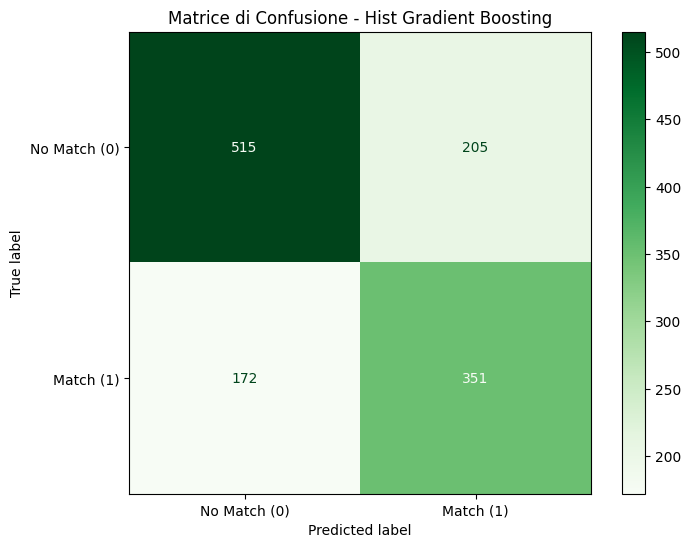

In [ ]:
# --- 5. Valutazione del Modello Migliore sul Test Set ---

# Identifichiamo il nome del modello migliore (il primo indice del DataFrame ordinato)
best_model_name_formatted = comparison_df.index[0]
# Convertiamo il nome formattato (es. "Random Forest") nel nome interno usato come chiave (es. "random_forest")
best_model_name_internal = best_model_name_formatted.lower().replace(' ', '_')
best_overall_estimator = best_estimators[best_model_name_internal]

print(f"\n--- Valutazione Finale del Miglior Modello in Assoluto: {best_model_name_formatted} ---")
print(f"Iperparametri scelti: {results[best_model_name_internal]['best_params']}")

# Facciamo le predizioni sul test set
y_pred_test = best_overall_estimator.predict(X_test)
y_proba_test = best_overall_estimator.predict_proba(X_test)[:, 1] # Probabilità per la classe positiva (per ROC-AUC)

# Importiamo le metriche necessarie
from sklearn.metrics import classification_report, f1_score, roc_auc_score, ConfusionMatrixDisplay

# Stampiamo il report di classificazione completo
print("\nClassification Report sul Test Set:")
print(classification_report(y_test, y_pred_test, target_names=['No Match (0)', 'Match (1)']))

# Stampiamo le metriche chiave separatamente per evidenziarle
final_f1 = f1_score(y_test, y_pred_test)
final_roc_auc = roc_auc_score(y_test, y_proba_test)

print("--- Metriche Finali sul Test Set ---")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC Score: {final_roc_auc:.4f}")
print("-" * 35)

# Visualizziamo la matrice di confusione del modello migliore
print("\nMatrice di Confusione del Miglior Modello:")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_overall_estimator,
    X_test,
    y_test,
    ax=ax,
    cmap='Greens', # Cambiamo colore per distinguerla dalle precedenti
    values_format='d',
    display_labels=['No Match (0)', 'Match (1)']
)
ax.set_title(f"Matrice di Confusione - {best_model_name_formatted}")
plt.show()